# **Signal 1D processing example using scipy, pandas and matplotlib**

We have one day 1Hz GNSS data at a point. We'll analyse the altitudes. The data are given in a csv file (https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/one_day.csv). the six columns in the file are: point_id, date/time, east, north, ellevation, code. The few first line:

```
1,2020-10-09 00:00:00,650769.386,237227.828,138.455,4
1,2020-10-09 00:00:01,650769.382,237227.823,138.452,4
1,2020-10-09 00:00:02,650769.382,237227.825,138.456,4
1,2020-10-09 00:00:03,650769.383,237227.824,138.455,4
1,2020-10-09 00:00:04,650769.384,237227.823,138.457,4
1,2020-10-09 00:00:05,650769.385,237227.824,138.464,4
```




Let's read in the input file using pandas.

In [159]:
import pandas as pd

names=['dt', 'east', 'north', 'elev', 'code'] # column names in pandas data set
data = pd.read_csv('https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/one_day.csv', sep=',', names=names, parse_dates=['dt'])
data.head

<bound method NDFrame.head of                        dt        east       north     elev  code
0     2020-10-09 00:00:00  650769.386  237227.828  138.455     4
1     2020-10-09 00:00:01  650769.382  237227.823  138.452     4
2     2020-10-09 00:00:02  650769.382  237227.825  138.456     4
3     2020-10-09 00:00:03  650769.383  237227.824  138.455     4
4     2020-10-09 00:00:04  650769.384  237227.823  138.457     4
...                   ...         ...         ...      ...   ...
86357 2020-10-09 23:59:55  650769.387  237227.831  138.451     4
86358 2020-10-09 23:59:56  650769.386  237227.831  138.447     4
86359 2020-10-09 23:59:57  650769.386  237227.830  138.444     4
86360 2020-10-09 23:59:58  650769.388  237227.829  138.445     4
86361 2020-10-09 23:59:59  650769.387  237227.828  138.445     4

[86362 rows x 5 columns]>

Let's examine some statistical values of the elevations (e.g. mean, min, max, standard deviation)

In [160]:
data['elev'].describe()

count    86362.000000
mean       138.448103
std          0.007281
min        138.419000
25%        138.443000
50%        138.448000
75%        138.453000
max        138.477000
Name: elev, dtype: float64

Note the max value! On the other hand we have only 86362 epoch, instead of 86400 (24 * 60 * 60).

The ranges of the quartiles are (25% - min, 50% - 25%, 75% - 50%, max - 75%):

```
34 mm, 5 mm, 5 mm, 25 mm
```

Let's examine the empirical density function of the elevations and the skewness of the data. If skewness is zero, then the densitiy function is symmetrical.

-0.008879604262117664

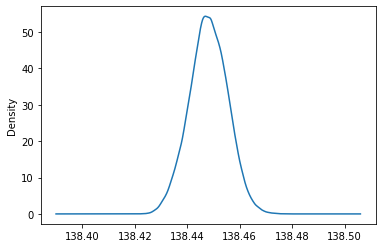

In [161]:
ax = data['elev'].plot.kde()
data['elev'].skew()

After some basic analysis let's display elevation, time diagramm.

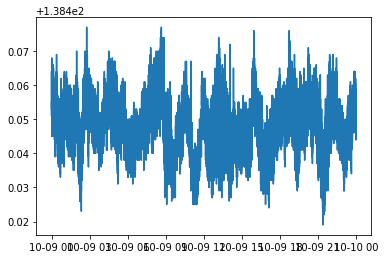

In [162]:
from matplotlib import pyplot as plt
ax = plt.plot(data['dt'], data['elev'])

We can realize the data are noisy and there may be some periodicy in it. First let's smooth data, to remove random noise.



In [163]:
data['smooth_elev'] = pd.DataFrame(data[['elev']].rolling(window=60).median())

Before we go further analysing data, find and fill the gaps in the data set.

In [164]:
from datetime import timedelta
deltas = data['dt'].diff()[1:]
dd = deltas[deltas > timedelta(seconds=1)]

We have two gaps (13 seconds and 27 seconds). Using the indices (24781 and 35908) we can find the time of the gap

In [165]:
for i in dd.index:
  print(data.iloc[[i-1,i]])


                       dt        east       north     elev  code  smooth_elev
24780 2020-10-09 06:53:00  650769.387  237227.834  138.444     4      138.446
24781 2020-10-09 06:53:13  650769.389  237227.833  138.444     4      138.446
                       dt        east       north     elev  code  smooth_elev
35907 2020-10-09 09:58:39  650769.380  237227.826  138.441     4      138.446
35908 2020-10-09 09:59:06  650769.383  237227.829  138.446     4      138.446


For further processing we have to fill these gaps. These two gaps are sorter the a minute, so we may use linear interpolation.

In [166]:
data['diff'] = data['dt'] - data['dt'].min()
data['seconds'] = data['diff'].dt.total_seconds() # time in seconds from the first epoch
x_orig = data['seconds'].to_numpy()
y_orig = data['smooth_elev'].to_numpy()
yy_orig = data['elev'].to_numpy()
import numpy as np
for i in range(0,59):   # generate smoothed data for the first minute
  y_orig[i] = np.median(yy_orig[0:i+1])
x = np.arange(0, x_orig[-1])
y = np.interp(x, x_orig, y_orig)

Let's display the first 5 minutes of original and smoothed data. Note the first minute missing from the smoothed data.

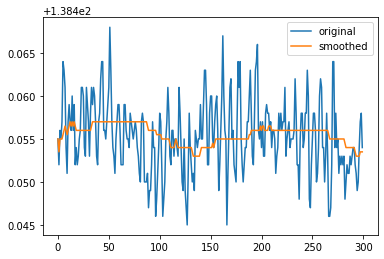

In [167]:
plt.plot(x_orig[0:300], data['elev'].to_numpy()[0:300], label='original')
plt.plot(x[0:300], y[0:300], label='smoothed')
plt.legend()

Now we start the spectral analysis of elevation time serie. First we remove the linear trend if there is any.

In [168]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
xx = x_orig.reshape(-1, 1)
model.fit(xx, y_orig)
intercept = model.intercept_    # intercept of y axis
coef = model.coef_              # slope
from math import atan, pi
print('{:.3f} {:.6f}'.format(intercept, atan(coef[0]) * 360 / pi))
y_no_trend = y - intercept - x * coef[0]   # remove trend from serie

138.449 -0.000003


Let's try to find the significant spectrums in data using FFT

In [169]:
from scipy.fft import rfft, rfftfreq, irfft
sample_rate = 1     # 1 Hz input data
nfreq = 10          # number of significanf frequences
n = x.size
yf = rfft(y_no_trend)
xf = rfftfreq(n, 1 / sample_rate)
ayf = np.abs(yf)
f = np.sort(ayf)[::-1][:nfreq]  # get the most significant frequencies
iyf = np.zeros(yf.shape[0])  # for inverse FFT
freqs = []
print("Significant frequences")
print("     FFT      index   frequency     wave l   ampl")
print("                         [Hz]       [hour]   [m]")
for v in f:
  i = np.where(ayf == v)[0][0]  # get index of frequency
  iyf[i] = ayf[i]
  print("{:10.1f} {:8d} {:12.8f} {:8.3f} {:8.4f}".format(v, i, xf[i], 1/ xf[i] / 3600, v / n))
ifft = irfft(iyf)   # inverse FFT for significant frequences

Significant frequences
     FFT      index   frequency     wave l   ampl
                         [Hz]       [hour]   [m]
     118.5       16   0.00018519    1.500   0.0014
     109.2       12   0.00013889    2.000   0.0013
     101.1        9   0.00010417    2.667   0.0012
      97.0       14   0.00016204    1.714   0.0011
      89.8        1   0.00001157   24.000   0.0010
      87.2        5   0.00005787    4.800   0.0010
      85.5        6   0.00006945    4.000   0.0010
      81.4       10   0.00011574    2.400   0.0009
      70.7        2   0.00002315   12.000   0.0008
      62.3        7   0.00008102    3.429   0.0007


Let's display frequency space.

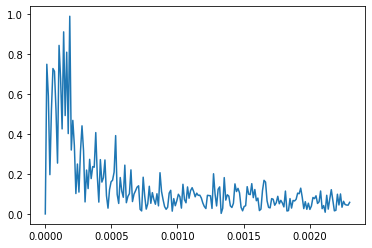

In [170]:
plt.plot(xf[:200], ayf[:200] / 120)

and the inverse FFT for the first 10 most significant frequences.

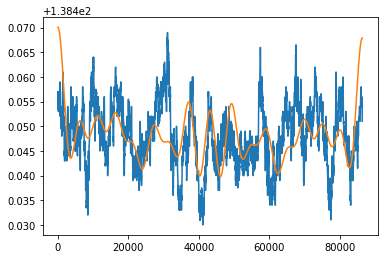

In [178]:
plt.plot(x, y, label='original')
yyy = ifft + intercept + x[:-1] * coef[0]
ifft.shape, x.size, x[:-1].size
plt.plot(x[:-1], ifft + intercept + x[:-1] * coef[0], label='FFT')
#plt.legend()